# ====== DECISION TREE IMPLEMENTATION FROM SCRATCH  =====

## Importing the libraries

In [1]:
# Install memory profiler for memory calculation
#!pip install -U memory_profiler

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from collections import Counter
# For time calculation
import time
# import DecisionTreeClassifier from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

# Data Purity Check

In [3]:
# Input is dataframe Target column
def data_purity_check(target_col):
    # When only one class is available for classification
    if len(set(target_col)) == 1:
        return True
    # When several classes are there for classification
    else:
        return False
    

# Classify

In [4]:
# Input is dataframe itself
def classification(cf):
    target_col = cf.label.values
    list_of_count_of_target = list(Counter(target_col).items())
    sorted_list_of_count_of_target = sorted(list_of_count_of_target, key=lambda x: x[1])
    result_class = sorted_list_of_count_of_target[-1][0]
    return(result_class)
    

# Potential Splits

In [5]:
# Input is dataframe itself
def find_potential_splits(fps_df):
    partition_box = dict()
    for col in fps_df.columns[:-1]: # Not including label column
        # Finding the partition corresponding to each feature
        unique_sorted_values_each_col = sorted(list(set(fps_df[col].values)))
        
        # Check for Continuous Variable
        if (fps_df[col].dtype.name in ['int', 'float', 'int64', 'float64']):
            # Finding the mid point between each sorted unique values in per column
            temp = [(unique_sorted_values_each_col[i] + unique_sorted_values_each_col[i-1])/2 for i in range(1, len(unique_sorted_values_each_col))]
        
        # Check for Categorical Variable
        elif (fps_df[col].dtype.name in ['object', 'category', 'bool', 'boolean']): 
            temp = unique_sorted_values_each_col
        
        # storing  the mid values list corresponding to each key (here column name)
        partition_box[col] = temp
    return partition_box

# Splitting the data
Column is selected first and then the value at which split is to be done

In [6]:
# Input is dataframe itself, splitting column, splitting point
# It will return all the points on either side of the split line
def splitting(s_df, col_of_split, point_of_split):
    
    # For Continuous Variable
    if s_df[col_of_split].dtype.name in ['int', 'float', 'int64', 'float64']:
        left_part_of_split = s_df[s_df[col_of_split] <= point_of_split]
        right_part_of_split = s_df[s_df[col_of_split] > point_of_split]
    # For Categorical Variable
    elif s_df[col_of_split].dtype.name in ['object', 'category', 'bool', 'boolean']:
        left_part_of_split = s_df[s_df[col_of_split] == point_of_split]
        right_part_of_split = s_df[s_df[col_of_split] != point_of_split]
    
    return left_part_of_split, right_part_of_split

# Calculation of entropy

In [7]:
def calculate_entropy(ce_df):
    target = ce_df.label.values
    target_values_count = np.array(list(Counter(target).values()))
    probabilities_of_each_class = target_values_count/float(sum(target_values_count))
    entropy = sum(probabilities_of_each_class *(-np.log2(probabilities_of_each_class)))
    return entropy

In [8]:
def calculate_overall_entropy(left_data, right_data):
    # Probability of occurance of left data points
    probability_left_data = left_data.shape[0]/ float(left_data.shape[0] + right_data.shape[0])
    # Probability of occurance of right data points
    probability_right_data = 1 - probability_left_data
    overall_entropy = (probability_left_data*calculate_entropy(left_data)) + (probability_right_data*calculate_entropy(right_data))
    return overall_entropy

# Calculation of gini-index

In [9]:
def calculate_individual_side_gini(cg_df):
    target = cg_df.label.values
    target_values_count = np.array(list(Counter(target).values()))
    probabilities_of_each_class = target_values_count/float(sum(target_values_count))
    impurity = 1 - sum(probabilities_of_each_class ** 2)
    return impurity

In [10]:
def calculate_overall_gini(left_data, right_data):
    # Probability of occurance of left data points
    probability_left_data = left_data.shape[0]/ float(left_data.shape[0] + right_data.shape[0])
    # Probability of occurance of right data points
    probability_right_data = 1 - probability_left_data
    # Calculating overall gini combining weigted impurities from both the left and right parts
    overall_impurity = (probability_left_data*calculate_individual_side_gini(left_data)) + (probability_right_data*calculate_individual_side_gini(right_data))
    return overall_impurity

# Finding the best possible split by Information Gain

In [11]:
def best_split_by_information_gain(ig_df, potential_split_dictionary):
    """Finding the feature or column and split_point with the highest information gain."""
    
    # Initial entropy to compare the improvement
    initial_entropy = calculate_entropy(ig_df)
    best_information_gain = -np.inf
    
    for split_col in potential_split_dictionary.keys():
        for split_value in potential_split_dictionary[split_col]:
            left_data, right_data = splitting(ig_df, split_col, split_value)
            current_overall_entropy = calculate_overall_entropy(left_data, right_data)
            current_information_gain = initial_entropy - current_overall_entropy
            
            if current_information_gain > best_information_gain:
                best_information_gain = current_information_gain
                best_col_of_split = split_col
                best_point_of_split = split_value
                
    return best_col_of_split, best_point_of_split

# Finding the best possible split by Gini Index

In [12]:
def best_split_by_gini(g_df, potential_split_dictionary):
    """Finding the feature or column and split_point with the minimum gini."""
    best_overall_gini = 7777
    for split_col in potential_split_dictionary.keys():
        for split_value in potential_split_dictionary[split_col]:
            left_data, right_data = splitting(g_df, split_col, split_value)
            current_overall_gini = calculate_overall_gini(left_data, right_data)
            
            if current_overall_gini < best_overall_gini:
                best_overall_gini = current_overall_gini
                best_col_of_split = split_col
                best_point_of_split = split_value
                
    return best_col_of_split, best_point_of_split

# Creating main decision tree function 

In [13]:
def decisionTreeClassifier(dt_df, current_depth = 0, max_depth=np.inf, split_type='entropy'):
    
    
    # Base case: When we get pure sample -> return the class
    if data_purity_check(dt_df.label) or current_depth == max_depth:
        return classification(dt_df)
    
    else:
        current_depth +=1
        potential_splits = find_potential_splits(dt_df)
        
        if len(potential_splits) == 0:
            return classification(dt_df)
            
        
        # Split point and column based on entropy and gini split_type
        if split_type == 'entropy':
            best_col_of_split, best_point_of_split = best_split_by_information_gain(dt_df, potential_splits)
        elif split_type == 'gini':
            best_col_of_split, best_point_of_split = best_split_by_gini(dt_df, potential_splits)
            
            
        left_part_of_split, right_part_of_split = splitting(dt_df, best_col_of_split, best_point_of_split)
        
        if dt_df[best_col_of_split].dtype.name in ['int', 'float', 'int64', 'float64']:   
            split_question = "{} <= {}".format(best_col_of_split, best_point_of_split)
            
        elif dt_df[best_col_of_split].dtype.name in ['object', 'category', 'bool', 'boolean']: 
            print("the best col of split is {} and best point is {}".format(best_col_of_split, best_point_of_split))
            split_question = "{} = {}".format(best_col_of_split, best_point_of_split)
            
            
        flow_dict = {split_question:[]}
        
        
        if_yes = decisionTreeClassifier(left_part_of_split, current_depth, max_depth) 
        if_no = decisionTreeClassifier(right_part_of_split, current_depth, max_depth)
        
        if if_yes == if_no:
            flow_dict = if_yes
        else:       
            flow_dict[split_question].append(if_yes)
            flow_dict[split_question].append(if_no)
        
    return flow_dict

# Classifying per row

In [14]:
def per_data_classify(test_row, reference_tree):
    # We first need to check our test row with the questions as per our reference tree
    main_question = list(reference_tree.keys())[0]
    question = main_question.split()
    # question[0] = feature_name
    # question[1] = <=
    # question[2] = split_point
    
    if question[1] == '<=':
        if test_row[question[0]] <= float(question[2]):
            answer = reference_tree[main_question][0]
        else:
            answer = reference_tree[main_question][1]
    else:
        if str(test_row[question[0]]) == question[2]:
            answer = reference_tree[main_question][0]
        else:
            answer = reference_tree[main_question][1]
        
    # Checking if answer is an instance of dictionary or not
    # If answer is one of the class then that is our final result otherwise if it's a dictionary we'll do recursion
    if not isinstance(answer, dict):
        return answer
    else:
        return per_data_classify(test_row, answer)

# Prediction

In [15]:
def predict(df_test, main_tree):
    prediction = []
    total_test_rows = df_test.shape[0]
    for ind in df_test.index:
        test_row = df_test.loc[ind]
        prediction.append(per_data_classify(test_row, main_tree)) 
    return prediction

# Train test split

In [16]:
def train_test_split(df_tt, train_size, seed_value=23):
    population_set = df_tt.index.tolist()
    length_of_dataset = df_tt.shape[0]
    # Setting the seed so that everytime the function is run we get same values for corresponding to a particular seed value
    random.seed(seed_value)
    # Considering train size to be given between 0 to 1
    train_index = random.sample(population_set, int(train_size*length_of_dataset))
    test_index = set(population_set) - set(train_index)
    df_tt_train = df_tt.loc[train_index] 
    df_tt_test = df_tt.loc[test_index]
    result = df_tt_train, df_tt_test
    return result
    

# =====================================================

# Testing the above code using a `Abalon` data

In [17]:
# Column names for DataSet
col_names = ["Sex", "Length", "Diameter", "Height", "Whole_Weight",
"Shucked_Weight", "Viscera_Weight", "Shell_Weight", "Rings"]
# Reading the data "Abalone"
df = pd.read_csv('abalone.data', names = col_names)
# Dropping the "Sex" column and storing it into "label" column at the end
target = df.Sex
df.drop(['Sex'], axis =1, inplace=True)
df['label'] = target
# Seeing top 5 rows of the data
df.head()

,Length,Diameter,Height,Whole_Weight,Shucked_Weight,Viscera_Weight,Shell_Weight,Rings,label
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,M
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,M
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,F
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,M
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,I


In [18]:
# Checking the datatypes of all the features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Length          4177 non-null   float64
 1   Diameter        4177 non-null   float64
 2   Height          4177 non-null   float64
 3   Whole_Weight    4177 non-null   float64
 4   Shucked_Weight  4177 non-null   float64
 5   Viscera_Weight  4177 non-null   float64
 6   Shell_Weight    4177 non-null   float64
 7   Rings           4177 non-null   int64  
 8   label           4177 non-null   object 
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


In [19]:
# Checking the Null Values in all the features
df.isna().sum()

Length            0
Diameter          0
Height            0
Whole_Weight      0
Shucked_Weight    0
Viscera_Weight    0
Shell_Weight      0
Rings             0
label             0
dtype: int64

C:\Users\vaibh\anaconda3\envs\env1\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Length', ylabel='Diameter'>

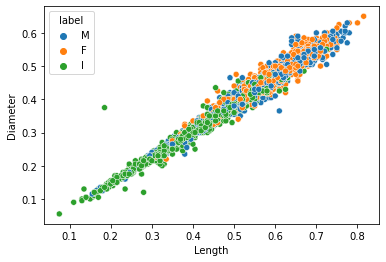

In [20]:
sns.scatterplot(df.Length, df.Diameter, hue = df.label)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Length          4177 non-null   float64
 1   Diameter        4177 non-null   float64
 2   Height          4177 non-null   float64
 3   Whole_Weight    4177 non-null   float64
 4   Shucked_Weight  4177 non-null   float64
 5   Viscera_Weight  4177 non-null   float64
 6   Shell_Weight    4177 non-null   float64
 7   Rings           4177 non-null   int64  
 8   label           4177 non-null   object 
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


# Train test split

## Comparison of my code and sklearn code based on time, accuracy, precision, recall with varying max_depth (split-criterian: Entropy)

In [22]:
# Using entropy as "criteria for creating leaf nodes"
# Changing the Max-depth and calculating the accuracy and f1-score
max_depth = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] # Changing from 2 to 20 
depth_time, depth_time_sk = [], []
depth_accuracy, depth_accuracy_sk = [], []
depth_f1_score, depth_f1_score_sk = [], []
depth_precision, depth_precision_sk = [], []
depth_recall, depth_recall_sk = [], []

# Looping through all the values of depths
for depth in max_depth:
    # Dividing into train and test based on split size
    df_train, df_test = train_test_split(df, .8)
    
    # Calculation and training of model and training time 
    start = time.time()
    # Model Training
    main_tree = decisionTreeClassifier(df_train, max_depth=depth, split_type='entropy')
    end = time.time()
    # Storing training time taken into depth_time list
    depth_time.append(end-start)
    
    #---------------------------------------------------------------------------------------
    #---------------------------------------------------------------------------------------    
    
    # Calculation and training of model and training time of sklearn model
    start = time.time()
    # Model Training
    sk_model = DecisionTreeClassifier(criterion='entropy', max_depth=depth)
    # fit the model
    sk_model.fit(df_train.iloc[:, :-1], df_train.iloc[:, -1])
    end = time.time()
    # Storing training time taken into depth_time list
    depth_time_sk.append(end-start)
    
    
    
    # Making prediction
    y_pred = predict(df_test, main_tree)
    y_pred_sk = sk_model.predict(df_test.iloc[:, :-1])
    
    # Finding Testing Accuracy
    y_accuracy = accuracy_score(df_test.iloc[:, -1], y_pred)
    depth_accuracy.append(y_accuracy)
    #-----------------------------------------------------
    y_accuracy_sk = accuracy_score(df_test.iloc[:, -1], y_pred_sk)
    depth_accuracy_sk.append(y_accuracy_sk)
    
    # Finding F1-Score
    y_f1_score = f1_score(df_test.iloc[:, -1], y_pred, average='micro')
    depth_f1_score.append(y_f1_score)
    #------------------------------------------------------
    y_f1_score_sk = f1_score(df_test.iloc[:, -1], y_pred_sk, average='micro')
    depth_f1_score_sk.append(y_f1_score_sk)
    
    # Finding Precision
    y_precision = precision_score(df_test.iloc[:, -1], y_pred, average='micro')
    depth_precision.append(y_precision)
    #------------------------------------------------------
    y_precision_sk = precision_score(df_test.iloc[:, -1], y_pred_sk, average='micro')
    depth_precision_sk.append(y_precision_sk)
    
    # Finding Recall
    y_recall = recall_score(df_test.iloc[:, -1], y_pred, average='micro')
    depth_recall.append(y_recall)
    #--------------------------------------------------------
    y_recall_sk = recall_score(df_test.iloc[:, -1], y_pred_sk, average='micro')
    depth_recall_sk.append(y_recall_sk)
    

# Creating dataframe of all the results achieved
varying_max_depth_entropy_dict = {'Depth':max_depth, 
                                 'Training_Time_My':depth_time,
                                 'Training_Time_Sk':depth_time_sk,
                                 'Testing_Accuracy_My':depth_accuracy,
                                 'Testing_Accuracy_Sk':depth_accuracy_sk,
                                 'Testing_F1_My':depth_f1_score,
                                 'Testing_F1_Sk':depth_f1_score_sk,
                                 'Testing_Precision_My':depth_precision,
                                 'Testing_Precision_Sk':depth_precision_sk,
                                 'Testing_Recall_My':depth_recall,
                                 'Testing_Recall_Sk':depth_recall_sk}


varying_max_depth_entropy_df = pd.DataFrame(varying_max_depth_entropy_dict)

In [23]:
varying_max_depth_entropy_df

,Depth,Training_Time_My,Training_Time_Sk,Testing_Accuracy_My,Testing_Accuracy_Sk,Testing_F1_My,Testing_F1_Sk,Testing_Precision_My,Testing_Precision_Sk,Testing_Recall_My,Testing_Recall_Sk
0,2,11.397162,0.015304,0.523923,0.523923,0.523923,0.523923,0.523923,0.523923,0.523923,0.523923
1,3,15.539232,0.013004,0.550239,0.550239,0.550239,0.550239,0.550239,0.550239,0.550239,0.550239
2,4,20.607886,0.015626,0.561005,0.561005,0.561005,0.561005,0.561005,0.561005,0.561005,0.561005
3,5,27.346186,0.016005,0.551435,0.547847,0.551435,0.547847,0.551435,0.547847,0.551435,0.547847
4,6,33.541787,0.015628,0.527512,0.527512,0.527512,0.527512,0.527512,0.527512,0.527512,0.527512
5,7,41.078960,0.016948,0.555024,0.551435,0.555024,0.551435,0.555024,0.551435,0.555024,0.551435
6,8,48.428648,0.019824,0.541866,0.547847,0.541866,0.547847,0.541866,0.547847,0.541866,0.547847
7,9,57.523864,0.031257,0.522727,0.521531,0.522727,0.521531,0.522727,0.521531,0.522727,0.521531
8,10,58.484606,0.034280,0.514354,0.520335,0.514354,0.520335,0.514354,0.520335,0.514354,0.520335
9,11,64.705553,0.031657,0.528708,0.522727,0.528708,0.522727,0.528708,0.522727,0.528708,0.522727


In [24]:
varying_max_depth_entropy_df.to_csv('varying_max_depth_entropy_df.csv')

## Comparison of my code and sklearn code based on time, accuracy, precision, recall with varying max_depth (split-criterian: gini)

In [25]:
# Using gini as "criteria for creating leaf nodes"
# Changing the Max-depth and calculating the accuracy and f1-score
max_depth = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] # Changing from 2 to 20 
depth_time, depth_time_sk = [], []
depth_accuracy, depth_accuracy_sk = [], []
depth_f1_score, depth_f1_score_sk = [], []
depth_precision, depth_precision_sk = [], []
depth_recall, depth_recall_sk = [], []

# Looping through all the values of depths
for depth in max_depth:
    # Dividing into train and test based on split size
    df_train, df_test = train_test_split(df, .8)
    
    # Calculation and training of model and training time 
    start = time.time()
    # Model Training
    main_tree = decisionTreeClassifier(df_train, max_depth=depth, split_type='gini')
    end = time.time()
    # Storing training time taken into depth_time list
    depth_time.append(end-start)
    
    #---------------------------------------------------------------------------------------
    #---------------------------------------------------------------------------------------    
    
    # Calculation and training of model and training time of sklearn model
    start = time.time()
    # Model Training
    sk_model = DecisionTreeClassifier(criterion='gini', max_depth=depth)
    # fit the model
    sk_model.fit(df_train.iloc[:, :-1], df_train.iloc[:, -1])
    end = time.time()
    # Storing training time taken into depth_time list
    depth_time_sk.append(end-start)
    
    
    
    # Making prediction
    y_pred = predict(df_test, main_tree)
    y_pred_sk = sk_model.predict(df_test.iloc[:, :-1])
    
    # Finding Accuracy
    y_accuracy = accuracy_score(df_test.iloc[:, -1], y_pred)
    depth_accuracy.append(y_accuracy)
    #-----------------------------------------------------
    y_accuracy_sk = accuracy_score(df_test.iloc[:, -1], y_pred_sk)
    depth_accuracy_sk.append(y_accuracy_sk)
    
    # Finding F1-Score
    y_f1_score = f1_score(df_test.iloc[:, -1], y_pred, average='micro')
    depth_f1_score.append(y_f1_score)
    #------------------------------------------------------
    y_f1_score_sk = f1_score(df_test.iloc[:, -1], y_pred_sk, average='micro')
    depth_f1_score_sk.append(y_f1_score_sk)
    
    # Finding Precision
    y_precision = precision_score(df_test.iloc[:, -1], y_pred, average='micro')
    depth_precision.append(y_precision)
    #------------------------------------------------------
    y_precision_sk = precision_score(df_test.iloc[:, -1], y_pred_sk, average='micro')
    depth_precision_sk.append(y_precision_sk)
    
    # Finding Recall
    y_recall = recall_score(df_test.iloc[:, -1], y_pred, average='micro')
    depth_recall.append(y_recall)
    #--------------------------------------------------------
    y_recall_sk = recall_score(df_test.iloc[:, -1], y_pred_sk, average='micro')
    depth_recall_sk.append(y_recall_sk)
    

# Creating dataframe of all the results achieved
varying_max_depth_gini_dict = {'Depth':max_depth, 
                                 'Training_Time_My':depth_time,
                                 'Training_Time_Sk':depth_time_sk,
                                 'Testing_Accuracy_My':depth_accuracy,
                                 'Testing_Accuracy_Sk':depth_accuracy_sk,
                                 'Testing_F1_My':depth_f1_score,
                                 'Testing_F1_Sk':depth_f1_score_sk,
                                 'Testing_Precision_My':depth_precision,
                                 'Testing_Precision_Sk':depth_precision_sk,
                                 'Testing_Recall_My':depth_recall,
                                 'Testing_Recall_Sk':depth_recall_sk}


varying_max_depth_gini_df = pd.DataFrame(varying_max_depth_gini_dict)

In [26]:
varying_max_depth_gini_df

,Depth,Training_Time_My,Training_Time_Sk,Testing_Accuracy_My,Testing_Accuracy_Sk,Testing_F1_My,Testing_F1_Sk,Testing_Precision_My,Testing_Precision_Sk,Testing_Recall_My,Testing_Recall_Sk
0,2,10.067374,0.008002,0.525120,0.525120,0.525120,0.525120,0.525120,0.525120,0.525120,0.525120
1,3,15.503729,0.008003,0.538278,0.528708,0.538278,0.528708,0.538278,0.528708,0.538278,0.528708
2,4,21.337162,0.008002,0.556220,0.558612,0.556220,0.558612,0.556220,0.558612,0.556220,0.558612
3,5,27.965792,0.012003,0.553828,0.549043,0.553828,0.549043,0.553828,0.549043,0.553828,0.549043
4,6,34.475090,0.012003,0.539474,0.553828,0.539474,0.553828,0.539474,0.553828,0.539474,0.553828
5,7,41.018971,0.016005,0.574163,0.551435,0.574163,0.551435,0.574163,0.551435,0.574163,0.551435
6,8,47.243325,0.012002,0.562201,0.538278,0.562201,0.538278,0.562201,0.538278,0.562201,0.538278
7,9,54.338260,0.031247,0.546651,0.537081,0.546651,0.537081,0.546651,0.537081,0.546651,0.537081
8,10,60.534106,0.020005,0.509569,0.540670,0.509569,0.540670,0.509569,0.540670,0.509569,0.540670
9,11,66.995388,0.020012,0.523923,0.532297,0.523923,0.532297,0.523923,0.532297,0.523923,0.532297


In [27]:
varying_max_depth_gini_df.to_csv('varying_max_depth_gini_df.csv')

## Comparing Accuracy and Time of my algo and Sklearn with varying training size (criterian-entropy)

In [28]:
# Dividing data into different train and test using different split value
# Considering split from 50% to 90% train split
train_size = [.5, .6, .7, .8, .9]
depth = [4, 7]

var_train_training_acc, var_train_training_acc_sk = [], []
var_train_time, var_train_time_sk = [], []
var_train_acc, var_train_acc_sk = [], []
var_train_f1_score, var_train_f1_score_sk = [], []
var_train_precision, var_train_precision_sk = [], []
var_train_recall, var_train_recall_sk = [], []
var_tree_depth, var_train_size = [], []
  
for d in depth:
    for i in train_size:
        var_tree_depth.append(d)
        var_train_size.append(i*100)
        
        # Dividing into train and test based on split size
        df_train, df_test = train_test_split(df, i)

        # Calculation and training of model and training time of My Algo
        start = time.time()
        main_tree = decisionTreeClassifier(df_train, max_depth=d, split_type='entropy')
        end = time.time()
        var_train_time.append(end-start)
        #---------------------------------------------------------------------------------------
        #---------------------------------------------------------------------------------------      
        # Calculation and training of model and training time of sklearn model
        start = time.time()
        # Model Training
        sk_model = DecisionTreeClassifier(criterion='entropy', max_depth=d)
        # fit the model
        sk_model.fit(df_train.iloc[:, :-1], df_train.iloc[:, -1])
        end = time.time()
        # Storing training time taken into depth_time list
        var_train_time_sk.append(end-start)
        
        
        # Making prediction on training data
        y_pred_train = predict(df_train.iloc[:, :-1], main_tree)
        y_pred_train_sk = sk_model.predict(df_train.iloc[:, :-1])

        # Finding Training Accuracy
        y_accuracy_train = accuracy_score(df_train.iloc[:, -1], y_pred_train)
        var_train_training_acc.append(y_accuracy_train)
        #-----------------------------------------------------
        y_accuracy_train_sk = accuracy_score(df_train.iloc[:, -1], y_pred_train_sk)
        var_train_training_acc_sk.append(y_accuracy_train_sk)
        
        
        # Making prediction on testing data
        y_pred = predict(df_test, main_tree)
        y_pred_sk = sk_model.predict(df_test.iloc[:, :-1])

        # Finding Accuracy
        y_accuracy = accuracy_score(df_test.iloc[:, -1], y_pred)
        var_train_acc.append(y_accuracy)
        #-----------------------------------------------------
        y_accuracy_sk = accuracy_score(df_test.iloc[:, -1], y_pred_sk)
        var_train_acc_sk.append(y_accuracy_sk)

        # Finding F1-Score
        y_f1_score = f1_score(df_test.iloc[:, -1], y_pred, average='micro')
        var_train_f1_score.append(y_f1_score)
        #------------------------------------------------------
        y_f1_score_sk = f1_score(df_test.iloc[:, -1], y_pred_sk, average='micro')
        var_train_f1_score_sk.append(y_f1_score_sk)

        # Finding Precision
        y_precision = precision_score(df_test.iloc[:, -1], y_pred, average='micro')
        var_train_precision.append(y_precision)
        #------------------------------------------------------
        y_precision_sk = precision_score(df_test.iloc[:, -1], y_pred_sk, average='micro')
        var_train_precision_sk.append(y_precision_sk)

        # Finding Recall
        y_recall = recall_score(df_test.iloc[:, -1], y_pred, average='micro')
        var_train_recall.append(y_recall)
        #--------------------------------------------------------
        y_recall_sk = recall_score(df_test.iloc[:, -1], y_pred_sk, average='micro')
        var_train_recall_sk.append(y_recall_sk)
        
# Creating dataframe of all the results achieved
varying_train_size_entropy_dict = {'Depth': var_tree_depth,
                                 'training_size':var_train_size, 
                                 'Training_Time_My':var_train_time,
                                 'Training_Time_Sk':var_train_time_sk,
                                 'Training_Accuracy_My':var_train_training_acc,
                                 'Training_Accuracy_Sk':var_train_training_acc_sk,
                                 'Testing_Accuracy_My':var_train_acc,
                                 'Testing_Accuracy_Sk':var_train_acc_sk,
                                 'Testing_F1_My':var_train_f1_score, 
                                 'Testing_F1_Sk':var_train_f1_score_sk,
                                 'Testing_Precision_My':var_train_precision, 
                                 'Testing_Precision_Sk':var_train_precision_sk,
                                 'Testing_Recall_My':var_train_recall, 
                                 'Testing_Recall_Sk':var_train_recall_sk }


varying_train_size_entropy_df = pd.DataFrame(varying_train_size_entropy_dict) 

In [29]:
varying_train_size_entropy_df

,Depth,training_size,Training_Time_My,Training_Time_Sk,Training_Accuracy_My,Training_Accuracy_Sk,Testing_Accuracy_My,Testing_Accuracy_Sk,Testing_F1_My,Testing_F1_Sk,Testing_Precision_My,Testing_Precision_Sk,Testing_Recall_My,Testing_Recall_Sk
0,4,50.0,14.934498,0.008349,0.568487,0.568487,0.546673,0.546194,0.546673,0.546194,0.546673,0.546194,0.546673,0.546194
1,4,60.0,17.813262,0.009103,0.571828,0.571828,0.533214,0.533214,0.533214,0.533214,0.533214,0.533214,0.533214,0.533214
2,4,70.0,19.736156,0.010004,0.576805,0.576805,0.548644,0.548644,0.548644,0.548644,0.548644,0.548644,0.548644,0.548644
3,4,80.0,21.391631,0.008013,0.571087,0.571087,0.561005,0.561005,0.561005,0.561005,0.561005,0.561005,0.561005,0.561005
4,4,90.0,23.157683,0.012002,0.570897,0.570897,0.598086,0.598086,0.598086,0.598086,0.598086,0.598086,0.598086,0.598086
5,7,50.0,28.464092,0.012001,0.635536,0.635536,0.526568,0.526089,0.526568,0.526089,0.526568,0.526089,0.526568,0.526089
6,7,60.0,33.460686,0.016004,0.640064,0.639266,0.518851,0.518253,0.518851,0.518253,0.518851,0.518253,0.518851,0.518253
7,7,70.0,37.352207,0.016005,0.647622,0.647622,0.526316,0.527911,0.526316,0.527911,0.526316,0.527911,0.526316,0.527911
8,7,80.0,39.456741,0.023996,0.624663,0.624663,0.555024,0.552632,0.555024,0.552632,0.555024,0.552632,0.555024,0.552632
9,7,90.0,42.004622,0.031253,0.615589,0.615589,0.586124,0.588517,0.586124,0.588517,0.586124,0.588517,0.586124,0.588517


In [30]:
varying_train_size_entropy_df.to_csv('varying_train_size_entropy_df.csv')

## Comparing Accuracy and Time of my algo and Sklearn with varying training size (criterian-gini)

In [32]:
# Dividing data into different train and test using different split value
# Considering split from 50% to 90% train split
train_size = [.5, .6, .7, .8, .9]
depth = [4, 7]

var_train_training_acc, var_train_training_acc_sk = [], []
var_train_time, var_train_time_sk = [], []
var_train_acc, var_train_acc_sk = [], []
var_train_f1_score, var_train_f1_score_sk = [], []
var_train_precision, var_train_precision_sk = [], []
var_train_recall, var_train_recall_sk = [], []
var_tree_depth, var_train_size = [], []
  
for d in depth:
    for i in train_size:
        var_tree_depth.append(d)
        var_train_size.append(i*100)
        
        # Dividing into train and test based on split size
        df_train, df_test = train_test_split(df, i)

        # Calculation and training of model and training time of My Algo
        start = time.time()
        main_tree = decisionTreeClassifier(df_train, max_depth=d, split_type='gini')
        end = time.time()
        var_train_time.append(end-start)
        #---------------------------------------------------------------------------------------
        #---------------------------------------------------------------------------------------      
        # Calculation and training of model and training time of sklearn model
        start = time.time()
        # Model Training
        sk_model = DecisionTreeClassifier(criterion='gini', max_depth=d)
        # fit the model
        sk_model.fit(df_train.iloc[:, :-1], df_train.iloc[:, -1])
        end = time.time()
        # Storing training time taken into depth_time list
        var_train_time_sk.append(end-start)
        
        
        # Making prediction on training data
        y_pred_train = predict(df_train.iloc[:, :-1], main_tree)
        y_pred_train_sk = sk_model.predict(df_train.iloc[:, :-1])

        # Finding Training Accuracy
        y_accuracy_train = accuracy_score(df_train.iloc[:, -1], y_pred_train)
        var_train_training_acc.append(y_accuracy_train)
        #-----------------------------------------------------
        y_accuracy_train_sk = accuracy_score(df_train.iloc[:, -1], y_pred_train_sk)
        var_train_training_acc_sk.append(y_accuracy_train_sk)
        
        
        # Making prediction on testing data
        y_pred = predict(df_test, main_tree)
        y_pred_sk = sk_model.predict(df_test.iloc[:, :-1])

        # Finding Accuracy
        y_accuracy = accuracy_score(df_test.iloc[:, -1], y_pred)
        var_train_acc.append(y_accuracy)
        #-----------------------------------------------------
        y_accuracy_sk = accuracy_score(df_test.iloc[:, -1], y_pred_sk)
        var_train_acc_sk.append(y_accuracy_sk)

        # Finding F1-Score
        y_f1_score = f1_score(df_test.iloc[:, -1], y_pred, average='micro')
        var_train_f1_score.append(y_f1_score)
        #------------------------------------------------------
        y_f1_score_sk = f1_score(df_test.iloc[:, -1], y_pred_sk, average='micro')
        var_train_f1_score_sk.append(y_f1_score_sk)

        # Finding Precision
        y_precision = precision_score(df_test.iloc[:, -1], y_pred, average='micro')
        var_train_precision.append(y_precision)
        #------------------------------------------------------
        y_precision_sk = precision_score(df_test.iloc[:, -1], y_pred_sk, average='micro')
        var_train_precision_sk.append(y_precision_sk)

        # Finding Recall
        y_recall = recall_score(df_test.iloc[:, -1], y_pred, average='micro')
        var_train_recall.append(y_recall)
        #--------------------------------------------------------
        y_recall_sk = recall_score(df_test.iloc[:, -1], y_pred_sk, average='micro')
        var_train_recall_sk.append(y_recall_sk)
        
# Creating dataframe of all the results achieved
varying_train_size_gini_dict = {'Depth': var_tree_depth,
                                 'training_size':var_train_size, 
                                 'Training_Time_My':var_train_time,
                                 'Training_Time_Sk':var_train_time_sk,
                                 'Training_Accuracy_My':var_train_training_acc,
                                 'Training_Accuracy_Sk':var_train_training_acc_sk,
                                 'Testing_Accuracy_My':var_train_acc,
                                 'Testing_Accuracy_Sk':var_train_acc_sk,
                                 'Testing_F1_My':var_train_f1_score, 
                                 'Testing_F1_Sk':var_train_f1_score_sk,
                                 'Testing_Precision_My':var_train_precision, 
                                 'Testing_Precision_Sk':var_train_precision_sk,
                                 'Testing_Recall_My':var_train_recall, 
                                 'Testing_Recall_Sk':var_train_recall_sk }


varying_train_size_gini_df = pd.DataFrame(varying_train_size_gini_dict) 

In [33]:
varying_train_size_gini_df

,Depth,training_size,Training_Time_My,Training_Time_Sk,Training_Accuracy_My,Training_Accuracy_Sk,Testing_Accuracy_My,Testing_Accuracy_Sk,Testing_F1_My,Testing_F1_Sk,Testing_Precision_My,Testing_Precision_Sk,Testing_Recall_My,Testing_Recall_Sk
0,4,50.0,17.806508,0.000000,0.571839,0.558429,0.544758,0.536142,0.544758,0.536142,0.544758,0.536142,0.544758,0.536142
1,4,60.0,17.873926,0.007002,0.569034,0.567837,0.540395,0.533214,0.540395,0.533214,0.540395,0.533214,0.540395,0.533214
2,4,70.0,19.893050,0.012002,0.573384,0.580226,0.549442,0.552632,0.549442,0.552632,0.549442,0.552632,0.549442,0.552632
3,4,80.0,21.291197,0.008002,0.567195,0.569291,0.556220,0.558612,0.556220,0.558612,0.556220,0.558612,0.556220,0.558612
4,4,90.0,23.052211,0.012055,0.572227,0.569034,0.610048,0.578947,0.610048,0.578947,0.610048,0.578947,0.610048,0.578947
5,7,50.0,29.280252,0.000000,0.644157,0.650862,0.519866,0.531833,0.519866,0.531833,0.519866,0.531833,0.519866,0.531833
6,7,60.0,33.994517,0.012004,0.635674,0.653232,0.534411,0.533812,0.534411,0.533812,0.534411,0.533812,0.534411,0.533812
7,7,70.0,38.923127,0.011994,0.656859,0.656175,0.523126,0.531100,0.523126,0.531100,0.523126,0.531100,0.523126,0.531100
8,7,80.0,40.967876,0.012002,0.628554,0.621371,0.574163,0.551435,0.574163,0.551435,0.574163,0.551435,0.574163,0.551435
9,7,90.0,43.771972,0.016004,0.618250,0.621442,0.602871,0.576555,0.602871,0.576555,0.602871,0.576555,0.602871,0.576555


In [ ]:
varying_train_size_gini_df.to_csv('varying_train_size_gini_df.csv')

# Plotting of charts for reports

In [ ]:
da = pd.read_csv('varying_train_size_entropy_df.csv')

fig, axes = plt.subplots(2, 2, figsize=(8, 8))

# For training accuracy (Information gain)
sns.lineplot(ax=axes[0,0], x = 'training_size', y='Training_Accuracy_My', data=da, hue='Depth')
sns.lineplot(ax=axes[0,1], x='training_size', y='Training_Accuracy_Sk', data=da, hue='Depth')
axes[0,0].set_title("Training Accuracy of My model (IG)")
axes[0,1].set_title("Training Accuracy of Sklearn model (IG)")

# For testing accuracy (Information Gain)
sns.lineplot(ax=axes[1,0], x = 'training_size', y='Testing_Accuracy_My', data=da, hue='Depth')
sns.lineplot(ax=axes[1,1], x='training_size', y='Testing_Accuracy_Sk', data=da, hue='Depth')
axes[1,0].set_title("Testing Accuracy of My model (IG)")
axes[1,1].set_title("Testing Accuracy of Sklearn model (IG)")



axes[0,0].grid()
axes[0,1].grid()
axes[1,0].grid()
axes[1,1].grid()
fig.tight_layout(pad=4.0)

In [ ]:
db = pd.read_csv('varying_train_size_gini_df.csv')

fig, axes = plt.subplots(2, 2, figsize=(8, 8))

# For training accuracy(Gini)
sns.lineplot(ax=axes[0,0], x = 'training_size', y='Training_Accuracy_My', data=db, hue='Depth')
sns.lineplot(ax=axes[0,1], x='training_size', y='Training_Accuracy_Sk', data=db, hue='Depth')
axes[0,0].set_title("Training Accuracy of My model (Gini)")
axes[0,1].set_title("Training Accuracy of Sklearn model (Gini)")

# For testing accuracy(Gini)
sns.lineplot(ax=axes[1,0], x = 'training_size', y='Testing_Accuracy_My', data=db, hue='Depth')
sns.lineplot(ax=axes[1,1], x='training_size', y='Testing_Accuracy_Sk', data=db, hue='Depth')
axes[1,0].set_title("Testing Accuracy of My model (Gini)")
axes[1,1].set_title("Testing Accuracy of Sklearn model (Gini)")

axes[0,0].grid()
axes[0,1].grid()
axes[1,0].grid()
axes[1,1].grid()
fig.tight_layout(pad=4.0)

#fig.set_title("Variation in training and testing accuracy based on training size", fontsize=16, y=-0.3, x=0.02, loc="center")


##### 